## Water Segmentation

# Imports

In [19]:
import os
import random
from pathlib import Path
import numpy as np
from tqdm import tqdm
import tifffile
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchmetrics

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
from scipy.ndimage import sobel
from spicy import ndimage

# CUDA Check

In [20]:
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device count:", torch.cuda.device_count())
    print("Current device index:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("Running on CPU only.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA device count: 1
Current device index: 0
Device name: NVIDIA GeForce RTX 3060 Laptop GPU


# Utility functions for reading data

In [21]:
def read_multiband_tif(path):
    arr = tifffile.imread(str(path))
    arr = np.asarray(arr, dtype=np.float32)
    if arr.ndim == 3 and arr.shape[0] <= 12 and arr.shape[0] != arr.shape[2]:
        return arr  # (C,H,W)
    if arr.ndim == 3:
        arr = np.moveaxis(arr, -1, 0)
    if arr.ndim == 2:
        arr = arr[None, ...]
    return arr

def read_mask(path):
    mask = tifffile.imread(str(path)) if str(path).endswith(".tif") else np.array(Image.open(path))
    mask = (mask > 0).astype(np.uint8)   
    return mask


# Feature engineering helpers

In [22]:
def safe_div(a, b, eps=1e-6):
    return a / (b + eps)

def compute_ndwi(green, nir):
    return safe_div(green - nir, green + nir)

def compute_mndwi(green, swir):
    return safe_div(green - swir, green + swir)

def compute_awei(blue, green, nir, swir1, swir2):
    return 4 * (green - swir1) - (0.25 * nir + 2.75 * swir2)

def compute_ndvi(red, nir):
    return safe_div(nir - red, nir + red)

# Dataset class with normalization + feature engineering

In [23]:
class MultiBandWaterDataset(Dataset):
    def __init__(self, images_dir, masks_dir, file_list=None,
                 add_features=True, feature_indices=None,
                 normalize_stats=None, transform=transform):
        self.images_dir = Path(images_dir)
        self.masks_dir = Path(masks_dir)
        self.filenames = sorted([p.stem for p in self.images_dir.glob("*.tif")])
        if file_list:
            self.filenames = [f for f in self.filenames if f in file_list]
        self.add_features = add_features
        self.feature_indices = feature_indices or {}
        self.normalize_stats = normalize_stats
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        name = self.filenames[idx]
        img_path = self.images_dir / (name + ".tif")

        # Load multispectral image (C,H,W)
        img = read_multiband_tif(img_path).astype(np.float32)
        C, H, W = img.shape

        # Find mask file
        mask_path = None
        for ext in (".tif", ".png", ".jpg", ".jpeg"):
            candidate = self.masks_dir / (name + ext)
            if candidate.exists():
                mask_path = candidate
                break
        mask = read_mask(mask_path).astype(np.float32) if mask_path else np.zeros((H, W), dtype=np.float32)

        # Feature engineering without water_occurrence
        extra_chs = []
        fi = self.feature_indices
        if self.add_features:
            if 'green' in fi and 'nir' in fi:
                extra_chs.append(compute_ndwi(img[fi['green']], img[fi['nir']])[None, ...])
            if 'green' in fi and 'swir1' in fi:
                extra_chs.append(compute_mndwi(img[fi['green']], img[fi['swir1']])[None, ...])
            if all(k in fi for k in ('coastal', 'green', 'nir', 'swir1', 'swir2')):
                extra_chs.append(compute_awei(img[fi['coastal']], img[fi['green']],
                                              img[fi['nir']], img[fi['swir1']], img[fi['swir2']])[None, ...])
            if 'red' in fi and 'nir' in fi:
                extra_chs.append(compute_ndvi(img[fi['red']], img[fi['nir']])[None, ...])
            # Removed water_occurrence-related features
            if 'green' in fi:
                edges = np.sqrt(
                    sobel(img[fi['green']], axis=0)**2 +
                    sobel(img[fi['green']], axis=1)**2
                )
                extra_chs.append(edges[None, ...])
            if 'blue' in fi and 'red' in fi:
                extra_chs.append(safe_div(img[fi['blue']], img[fi['red']])[None, ...])
            if 'green' in fi:
                local_mean = ndimage.uniform_filter(img[fi['green']], size=5)
                local_sqr_mean = ndimage.uniform_filter(img[fi['green']]**2, size=5)
                local_var = local_sqr_mean - local_mean**2
                extra_chs.append(local_var[None, ...])

        if extra_chs:
            img = np.concatenate([img] + extra_chs, axis=0)

        # Normalization
        if self.normalize_stats is not None:
            mean, std = self.normalize_stats['mean'], self.normalize_stats['std']
            if mean.shape[0] != img.shape[0]:
                extra = img.shape[0] - mean.shape[0]
                mean = np.concatenate([mean, np.zeros(extra)], axis=0)
                std = np.concatenate([std, np.ones(extra)], axis=0)
            img = (img - mean[:, None, None]) / (std[:, None, None] + 1e-6)
        else:
            chmin = img.reshape(img.shape[0], -1).min(axis=1)
            chmax = img.reshape(img.shape[0], -1).max(axis=1)
            denom = chmax - chmin; denom[denom==0] = 1.0
            img = (img - chmin[:, None, None]) / denom[:, None, None]

        # Apply transformations
        if self.transform:
            augmented = self.transform(image=img.transpose(1, 2, 0), mask=mask)
            img = augmented['image'].float()
            mask = augmented['mask'].long()
        else:
            img = torch.from_numpy(img).float()
            mask = torch.from_numpy(mask).long()

        return img, mask, name

# Compute dataset stats (mean/std per channel)

In [24]:
def compute_dataset_stats(dataset):
    """Compute per-channel mean & std over the whole dataset."""
    sums, sq_sums, n_pixels = None, None, 0

    for img, _, _ in tqdm(dataset, desc="Computing stats"):
        arr = img.numpy()  # (C,H,W)
        if sums is None:
            sums = np.zeros(arr.shape[0], dtype=np.float64)
            sq_sums = np.zeros(arr.shape[0], dtype=np.float64)

        sums += arr.reshape(arr.shape[0], -1).sum(axis=1)
        sq_sums += (arr.reshape(arr.shape[0], -1) ** 2).sum(axis=1)
        n_pixels += arr.shape[1] * arr.shape[2]

    mean = sums / n_pixels
    std = np.sqrt(sq_sums / n_pixels - mean**2)
    return mean, std



# Band Visualization

In [25]:
def visualize_bands(img_arr, band_names=None, swap_green_blue=False, max_display=12):
    C, H, W = img_arr.shape
    n = min(C, max_display)
    plt.figure(figsize=(15, 6))
    for i in range(n):
        plt.subplot(2, (n+1)//2, i+1)
        ch = img_arr[i]
        if swap_green_blue and band_names:
            if band_names[i].lower() == 'green':
                j = band_names.index('blue')
                ch = img_arr[j]
        plt.imshow(ch, cmap='gray')
        plt.title(band_names[i] if band_names else f"Band {i}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Setup dataset, dataloaders, and model

In [26]:
def compute_water_ratio(masks_dir, filenames):
    """Return dictionary {filename: water_fraction} for stratified splitting."""
    ratios = {}
    for name in tqdm(filenames, desc="Scanning masks for water ratio"):
        for ext in (".tif", ".png", ".jpg", ".jpeg"):
            mask_path = Path(masks_dir) / f"{name}{ext}"
            if mask_path.exists():
                mask = read_mask(mask_path).astype(np.uint8)
                ratios[name] = mask.mean()  # fraction of pixels that are water
                break
    return ratios


In [27]:
images_dir=Path("/mnt/c/Users/Rowan/Desktop/Cellula_Internship/Task2/data/images")
masks_dir=Path("/mnt/c/Users/Rowan/Desktop/Cellula_Internship/Task2/data/labels")

filenames = sorted([p.stem for p in Path(images_dir).glob("*.tif")])


ratios = compute_water_ratio(masks_dir, filenames)


labels = [1 if ratios.get(name, 0) > 0 else 0 for name in filenames]

train_files, val_files = train_test_split(
    filenames,
    test_size=0.2,
    random_state=123,
    stratify=labels
)

print(f"Total: {len(filenames)} | Train: {len(train_files)} | Val: {len(val_files)}")
print(f"Water in Train: {sum([labels[filenames.index(f)] for f in train_files])}")
print(f"Water in Val:   {sum([labels[filenames.index(f)] for f in val_files])}")

Scanning masks for water ratio: 100%|██████████| 306/306 [00:02<00:00, 146.82it/s]

Total: 306 | Train: 244 | Val: 62
Water in Train: 208
Water in Val:   53


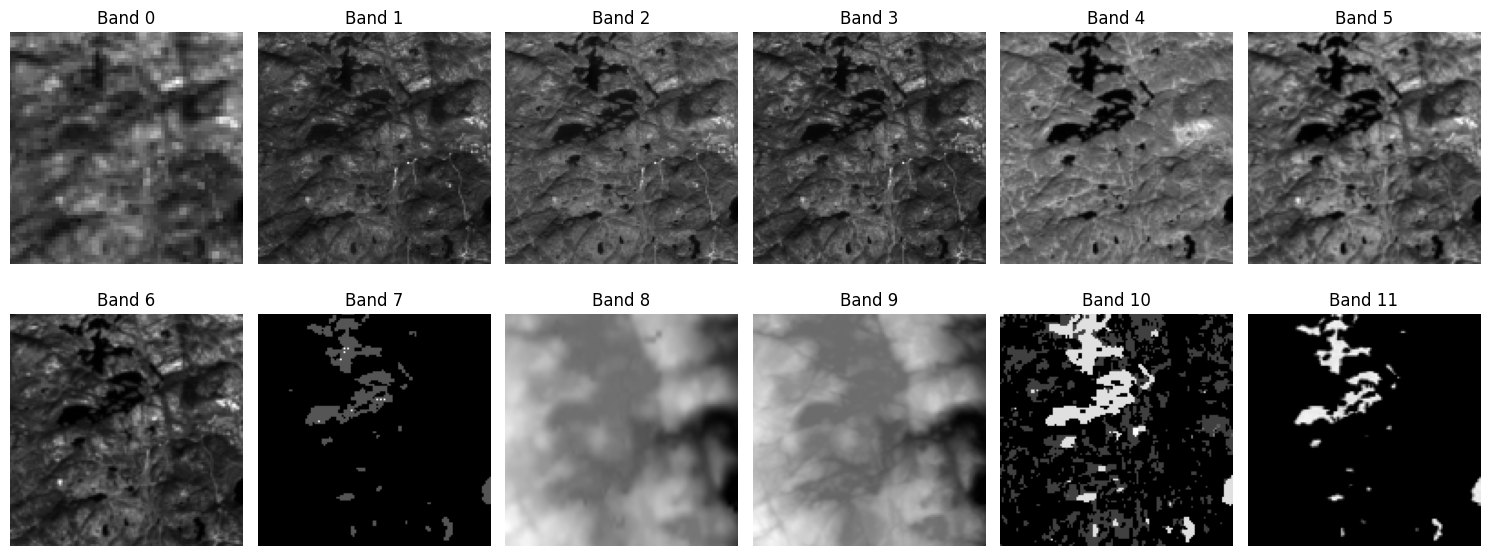

In [28]:
# visualize each band of a sample image
visualize_bands(read_multiband_tif(images_dir / (filenames[0] + ".tif")), max_display=12)

In [29]:
indices = {
    'coastal': 1,
    'blue': 1,
    'green': 2,
    'red': 3,
    'nir': 7,
    'swir1': 10,
    'swir2': 11
}


# Full dataset for computing stats
full_dataset = MultiBandWaterDataset(
    images_dir=images_dir,
    masks_dir=masks_dir,
    add_features=True,
    feature_indices=indices,
    normalize_stats=None,
    transform=None
)

# Compute normalization stats
mean, std = compute_dataset_stats(full_dataset)
normalize_stats = {"mean": mean, "std": std}
print("Global mean per channel:", mean)
print("Global std per channel:", std)

# Train and validation datasets with transformations
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=30, p=0.5, border_mode=0),
    ToTensorV2()
])

train_ds = MultiBandWaterDataset(
    images_dir=images_dir,
    masks_dir=masks_dir,
    file_list=train_files,
    transform=transform,
    add_features=True,
    feature_indices=indices,
    normalize_stats=normalize_stats
)

val_ds = MultiBandWaterDataset(
    images_dir=images_dir,
    masks_dir=masks_dir,
    file_list=val_files,
    add_features=True,
    feature_indices=indices,
    normalize_stats=normalize_stats
)

# Data loaders
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=2)


Computing stats: 100%|██████████| 306/306 [00:04<00:00, 64.55it/s] 

Global mean per channel: [0.32674827 0.24657207 0.26373111 0.27969094 0.39453183 0.42248226
 0.34596496 0.2303573  0.33329151 0.32334595 0.35317658 0.09641267
 0.76047202 0.77030838 0.26845922 0.21744306 0.09243886 0.49666416
 0.04972743]
Global std per channel: [0.17631651 0.1534262  0.15465419 0.16799942 0.2017877  0.23184903
 0.22009909 0.2920878  0.24839259 0.2275742  0.29851438 0.27606208
 0.17555224 0.20720225 0.15602372 0.16683395 0.10836867 0.22973999
 0.08968693]



/mnt/c/Users/Rowan/Desktop/Cellula_Internship/.venv/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [30]:
all_files = sorted([p.stem for p in images_dir.glob("*.tif")])
count_with_water = sum([read_mask(masks_dir / (f + ".png")).sum() > 0 for f in all_files])
print("Images with water:", count_with_water, "/", len(all_files))

Images with water: 261 / 306


# Unet Model

In [31]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout),
        )
    def forward(self, x): return self.net(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=0.1):
        super().__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch, dropout=dropout)
        )
    def forward(self, x): return self.mpconv(x)

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True, dropout=0.3):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_ch, out_ch, dropout=dropout)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_ch, out_ch, dropout=dropout)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # padding if sizes mismatch
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


# --- Full TransUNet ---
class TransUNet(nn.Module):
    def __init__(self, in_ch=22, n_classes=1, base_c=32, bilinear=True, dropout=0.3):
        super().__init__()
        self.inc = DoubleConv(in_ch, base_c, dropout=dropout)
        self.down1 = Down(base_c, base_c*2, dropout=dropout)
        self.down2 = Down(base_c*2, base_c*4, dropout=dropout)
        self.down3 = Down(base_c*4, base_c*8, dropout=dropout)
        factor = 2 if bilinear else 1
        self.down4 = Down(base_c*8, base_c*16 // factor, dropout=dropout)

        

        # Decoder
        self.up1 = Up(base_c*16, base_c*8 // factor, bilinear, dropout=dropout)
        self.up2 = Up(base_c*8, base_c*4 // factor, bilinear, dropout=dropout)
        self.up3 = Up(base_c*4, base_c*2 // factor, bilinear, dropout=dropout)
        self.up4 = Up(base_c*2, base_c, bilinear, dropout=dropout)
        self.outc = nn.Conv2d(base_c, n_classes, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)


        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        return self.outc(x)

In [32]:

sample_img, _, _ = train_ds[0]
in_channels = sample_img.shape[0]
num_channels = sample_img.shape[0]
print("Input channels for model:", in_channels)

Input channels for model: 19


In [33]:
class BCE_Dice_FocalLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=2.0, bce_weight=1.0, dice_weight=1.0, focal_weight=1.0):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([5.0]))  # boost positives
        self.alpha = alpha
        self.gamma = gamma
        self.bce_w = bce_weight
        self.dice_w = dice_weight
        self.focal_w = focal_weight

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        targets = targets.float()

        # BCE
        bce_loss = self.bce(logits, targets) # pixel-wise BCE

        # Dice
        smooth = 1e-6
        intersection = (probs * targets).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (probs.sum() + targets.sum() + smooth) # optimizes overlap between prediction & ground truth

        # Focal
        pt = torch.where(targets == 1, probs, 1 - probs)
        focal_loss = - (self.alpha * (1 - pt) ** self.gamma * torch.log(pt + smooth)).mean() # focuses on hard examples

        return self.bce_w * bce_loss + self.dice_w * dice_loss + self.focal_w * focal_loss


# Metrics

In [34]:
def compute_metrics(y_pred, y_true, threshold=0.5, smooth=1e-6):
    with torch.no_grad():
        probs = torch.sigmoid(y_pred)
        preds = (probs > threshold).float()
        y_true = y_true.float()

        preds = preds.view(preds.size(0), -1)
        y_true = y_true.view(y_true.size(0), -1)

        tp = (preds * y_true).sum(dim=1)
        fp = (preds * (1 - y_true)).sum(dim=1)
        fn = ((1 - preds) * y_true).sum(dim=1)

        precision = ((tp + smooth) / (tp + fp + smooth)).mean().item()
        recall    = ((tp + smooth) / (tp + fn + smooth)).mean().item()
        f1        = (2 * precision * recall) / (precision + recall + smooth)
        iou       = ((tp + smooth) / (tp + fp + fn + smooth)).mean().item()  # IoU for segmentation to evaluate overlap between prediction & ground truth

        return {
            "precision": precision,
            "recall": recall,
            "f1": f1,   
            "iou": iou
        }


# Training loop

In [35]:
def train_model(model, train_loader, val_loader, optimizer, scheduler, device, epochs):
    criterion = BCE_Dice_FocalLoss().to(device)
    history = {"train_loss": [], "val_loss": [], "iou": [], "f1": [], "precision": [], "recall": []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X, y, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            X, y = X.to(device), y.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        val_loss, precision, recall, f1, iou = 0.0, 0, 0, 0, 0
        with torch.no_grad():
            for X, y, _ in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                X, y = X.to(device), y.to(device).float().unsqueeze(1)
                outputs = model(X)
                loss = criterion(outputs, y)
                val_loss += loss.item()

                metrics = compute_metrics(outputs, y)
                precision += metrics["precision"]
                recall    += metrics["recall"]
                f1        += metrics["f1"]
                iou       += metrics["iou"]

        val_loss /= len(val_loader)
        precision /= len(val_loader)
        recall    /= len(val_loader)
        f1        /= len(val_loader)
        iou       /= len(val_loader)

        # Step LR scheduler
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"IoU: {iou:.4f} | F1: {f1:.4f} | Prec: {precision:.4f} | Rec: {recall:.4f}")

        # Save history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["iou"].append(iou)
        history["f1"].append(f1)
        history["precision"].append(precision)
        history["recall"].append(recall)

    return history


In [48]:
epochs = 60
model = TransUNet(in_ch=19, n_classes=1, base_c=32, dropout=0.1).to(device) 
optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=5, factor=0.5, verbose=True)

history = train_model(model, train_loader, val_loader, optimizer, scheduler, device, epochs)

/mnt/c/Users/Rowan/Desktop/Cellula_Internship/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/60 [Val]: 100%|██████████| 16/16 [00:00<00:00, 21.65it/s]


Epoch 1/60 | Train Loss: 2.0048 | Val Loss: 2.8912 | IoU: 0.0074 | F1: 0.1148 | Prec: 0.2285 | Rec: 0.1495


Epoch 2/60 [Val]: 100%|██████████| 16/16 [00:00<00:00, 22.22it/s]


Epoch 2/60 | Train Loss: 1.7288 | Val Loss: 3.2213 | IoU: 0.0039 | F1: 0.0791 | Prec: 0.1792 | Rec: 0.1446


Epoch 3/60 [Val]: 100%|██████████| 16/16 [00:01<00:00, 15.86it/s]


Epoch 3/60 | Train Loss: 1.5748 | Val Loss: 2.5349 | IoU: 0.0182 | F1: 0.1341 | Prec: 0.3057 | Rec: 0.1590


Epoch 4/60 [Val]: 100%|██████████| 16/16 [00:01<00:00, 15.20it/s]


Epoch 4/60 | Train Loss: 1.5450 | Val Loss: 2.2121 | IoU: 0.1947 | F1: 0.3448 | Prec: 0.4396 | Rec: 0.3500


Epoch 5/60 [Val]: 100%|██████████| 16/16 [00:01<00:00, 12.94it/s]


Epoch 5/60 | Train Loss: 1.6017 | Val Loss: 2.3595 | IoU: 0.1539 | F1: 0.2326 | Prec: 1.0000 | Rec: 0.1539


Epoch 6/60 [Val]: 100%|██████████| 16/16 [00:00<00:00, 17.35it/s]


Epoch 6/60 | Train Loss: 1.4854 | Val Loss: 2.3492 | IoU: 0.0174 | F1: 0.1294 | Prec: 0.3179 | Rec: 0.1581


Epoch 7/60 [Val]: 100%|██████████| 16/16 [00:00<00:00, 17.30it/s]


Epoch 7/60 | Train Loss: 1.5469 | Val Loss: 2.3306 | IoU: 0.1294 | F1: 0.2139 | Prec: 0.9123 | Rec: 0.1450


Epoch 8/60 [Val]: 100%|██████████| 16/16 [00:00<00:00, 17.21it/s]


Epoch 8/60 | Train Loss: 1.4554 | Val Loss: 2.2673 | IoU: 0.1237 | F1: 0.2178 | Prec: 0.7165 | Rec: 0.1552


Epoch 9/60 [Val]: 100%|██████████| 16/16 [00:00<00:00, 17.62it/s]


Epoch 9/60 | Train Loss: 1.4207 | Val Loss: 2.1572 | IoU: 0.2935 | F1: 0.4450 | Prec: 0.3007 | Rec: 0.9921


Epoch 10/60 [Val]: 100%|██████████| 16/16 [00:00<00:00, 16.59it/s]


Epoch 10/60 | Train Loss: 1.4388 | Val Loss: 2.2817 | IoU: 0.1238 | F1: 0.2236 | Prec: 0.8124 | Rec: 0.1552


Epoch 11/60 [Val]: 100%|██████████| 16/16 [00:00<00:00, 17.36it/s]


Epoch 11/60 | Train Loss: 1.5165 | Val Loss: 2.0957 | IoU: 0.3798 | F1: 0.5664 | Prec: 0.4459 | Rec: 0.8305


Epoch 12/60 [Val]: 100%|██████████| 16/16 [00:00<00:00, 16.42it/s]


Epoch 12/60 | Train Loss: 1.4792 | Val Loss: 2.4337 | IoU: 0.1520 | F1: 0.2299 | Prec: 1.0000 | Rec: 0.1520


Epoch 13/60 [Val]: 100%|██████████| 16/16 [00:00<00:00, 17.59it/s]


Epoch 13/60 | Train Loss: 1.4883 | Val Loss: 2.2315 | IoU: 0.3655 | F1: 0.5819 | Prec: 0.5522 | Rec: 0.6742


Epoch 14/60 [Val]: 100%|██████████| 16/16 [00:00<00:00, 17.49it/s]


Epoch 14/60 | Train Loss: 1.4292 | Val Loss: 2.2319 | IoU: 0.1580 | F1: 0.2370 | Prec: 0.9998 | Rec: 0.1581


Epoch 15/60 [Val]: 100%|██████████| 16/16 [00:00<00:00, 17.49it/s]


Epoch 15/60 | Train Loss: 1.4818 | Val Loss: 2.4279 | IoU: 0.1511 | F1: 0.2289 | Prec: 1.0000 | Rec: 0.1511


Epoch 16/60 [Val]: 100%|██████████| 16/16 [00:00<00:00, 16.41it/s]


Epoch 16/60 | Train Loss: 1.5201 | Val Loss: 2.0918 | IoU: 0.3975 | F1: 0.5998 | Prec: 0.5677 | Rec: 0.6887


Epoch 17/60 [Val]: 100%|██████████| 16/16 [00:00<00:00, 17.70it/s]


Epoch 17/60 | Train Loss: 1.3605 | Val Loss: 2.2129 | IoU: 0.4347 | F1: 0.6168 | Prec: 0.6723 | Rec: 0.6125


Epoch 18/60 [Val]: 100%|██████████| 16/16 [00:00<00:00, 16.61it/s]


Epoch 18/60 | Train Loss: 1.3525 | Val Loss: 2.0921 | IoU: 0.3031 | F1: 0.4470 | Prec: 0.3040 | Rec: 0.9685


Epoch 19/60 [Val]: 100%|██████████| 16/16 [00:00<00:00, 17.56it/s]


Epoch 19/60 | Train Loss: 1.4600 | Val Loss: 2.0135 | IoU: 0.2988 | F1: 0.4460 | Prec: 0.3010 | Rec: 0.9972


Epoch 20/60 [Val]: 100%|██████████| 16/16 [00:00<00:00, 18.22it/s]


Epoch 20/60 | Train Loss: 1.3808 | Val Loss: 2.2360 | IoU: 0.1489 | F1: 0.2265 | Prec: 1.0000 | Rec: 0.1489


Epoch 21/60 [Val]: 100%|██████████| 16/16 [00:00<00:00, 17.78it/s]


Epoch 21/60 | Train Loss: 1.3391 | Val Loss: 2.3335 | IoU: 0.1568 | F1: 0.2356 | Prec: 1.0000 | Rec: 0.1568


Epoch 22/60 [Val]: 100%|██████████| 16/16 [00:00<00:00, -49.39it/s]


Epoch 22/60 | Train Loss: 1.3245 | Val Loss: 2.0297 | IoU: 0.3064 | F1: 0.4485 | Prec: 0.3081 | Rec: 0.9345


Epoch 23/60 [Val]: 100%|██████████| 16/16 [00:00<00:00, 16.76it/s]


Epoch 23/60 | Train Loss: 1.3840 | Val Loss: 2.2112 | IoU: 0.2946 | F1: 0.4837 | Prec: 0.5400 | Rec: 0.5135


Epoch 24/60 [Val]: 100%|██████████| 16/16 [00:00<00:00, 16.93it/s]


Epoch 24/60 | Train Loss: 1.4622 | Val Loss: 2.2706 | IoU: 0.1201 | F1: 0.2171 | Prec: 0.8984 | Rec: 0.1513


Epoch 25/60 [Val]: 100%|██████████| 16/16 [00:01<00:00, 15.81it/s]


Epoch 25/60 | Train Loss: 1.3464 | Val Loss: 2.2557 | IoU: 0.1189 | F1: 0.2171 | Prec: 0.9063 | Rec: 0.1501


Epoch 26/60 [Val]: 100%|██████████| 16/16 [00:00<00:00, 17.00it/s]


Epoch 26/60 | Train Loss: 1.3711 | Val Loss: 2.0731 | IoU: 0.3921 | F1: 0.5535 | Prec: 0.9648 | Rec: 0.4155


Epoch 27/60 [Val]: 100%|██████████| 16/16 [00:00<00:00, 17.28it/s]


Epoch 27/60 | Train Loss: 1.4678 | Val Loss: 2.0718 | IoU: 0.3432 | F1: 0.5082 | Prec: 0.3724 | Rec: 0.8690


Epoch 28/60 [Val]: 100%|██████████| 16/16 [00:00<00:00, 17.23it/s]


Epoch 28/60 | Train Loss: 1.3745 | Val Loss: 2.1730 | IoU: 0.3951 | F1: 0.6077 | Prec: 0.5639 | Rec: 0.7170


Epoch 29/60 [Val]: 100%|██████████| 16/16 [00:00<00:00, 17.46it/s]


Epoch 29/60 | Train Loss: 1.4007 | Val Loss: 2.1653 | IoU: 0.4754 | F1: 0.6370 | Prec: 0.9238 | Rec: 0.5140


Epoch 30/60 [Val]: 100%|██████████| 16/16 [00:00<00:00, 17.47it/s]


Epoch 30/60 | Train Loss: 1.3237 | Val Loss: 2.1901 | IoU: 0.4619 | F1: 0.6372 | Prec: 0.9052 | Rec: 0.5180


Epoch 31/60 [Val]: 100%|██████████| 16/16 [00:01<00:00, 13.29it/s]


Epoch 31/60 | Train Loss: 1.3169 | Val Loss: 2.2275 | IoU: 0.3342 | F1: 0.5045 | Prec: 0.9303 | Rec: 0.3701


Epoch 32/60 [Val]: 100%|██████████| 16/16 [00:00<00:00, 17.73it/s]


Epoch 32/60 | Train Loss: 1.3231 | Val Loss: 2.2154 | IoU: 0.4079 | F1: 0.5632 | Prec: 0.9706 | Rec: 0.4205


Epoch 33/60 [Val]: 100%|██████████| 16/16 [00:01<00:00, 10.16it/s]


Epoch 33/60 | Train Loss: 1.3100 | Val Loss: 2.1221 | IoU: 0.4523 | F1: 0.6336 | Prec: 0.8049 | Rec: 0.5608


Epoch 34/60 [Val]: 100%|██████████| 16/16 [00:01<00:00, 10.18it/s]


Epoch 34/60 | Train Loss: 1.3038 | Val Loss: 2.1127 | IoU: 0.2950 | F1: 0.4713 | Prec: 0.3418 | Rec: 0.8241


Epoch 35/60 [Val]: 100%|██████████| 16/16 [00:01<00:00, 10.21it/s]


Epoch 35/60 | Train Loss: 1.2771 | Val Loss: 2.2293 | IoU: 0.3697 | F1: 0.5213 | Prec: 0.9754 | Rec: 0.3789


Epoch 36/60 [Val]: 100%|██████████| 16/16 [00:01<00:00, 10.83it/s]


Epoch 36/60 | Train Loss: 1.3275 | Val Loss: 2.0358 | IoU: 0.4728 | F1: 0.6587 | Prec: 0.8401 | Rec: 0.5759


Epoch 37/60 [Val]: 100%|██████████| 16/16 [00:01<00:00, 10.11it/s]


Epoch 37/60 | Train Loss: 1.2827 | Val Loss: 2.2818 | IoU: 0.1463 | F1: 0.2235 | Prec: 1.0000 | Rec: 0.1463


Epoch 38/60 [Val]: 100%|██████████| 16/16 [00:01<00:00, 10.20it/s]


Epoch 38/60 | Train Loss: 1.3051 | Val Loss: 2.1685 | IoU: 0.2942 | F1: 0.4712 | Prec: 0.3497 | Rec: 0.7840


Epoch 39/60 [Val]: 100%|██████████| 16/16 [00:01<00:00, 10.54it/s]


Epoch 39/60 | Train Loss: 1.3450 | Val Loss: 2.0795 | IoU: 0.3073 | F1: 0.4563 | Prec: 0.3204 | Rec: 0.8977


Epoch 40/60 [Val]: 100%|██████████| 16/16 [00:01<00:00, 10.51it/s]


Epoch 40/60 | Train Loss: 1.2404 | Val Loss: 2.1235 | IoU: 0.3010 | F1: 0.4521 | Prec: 0.3157 | Rec: 0.9098


Epoch 41/60 [Val]: 100%|██████████| 16/16 [00:01<00:00, 10.37it/s]


Epoch 41/60 | Train Loss: 1.2288 | Val Loss: 2.1829 | IoU: 0.4041 | F1: 0.6203 | Prec: 0.7166 | Rec: 0.5704


Epoch 42/60 [Val]: 100%|██████████| 16/16 [00:01<00:00, 10.45it/s]


Epoch 42/60 | Train Loss: 1.2737 | Val Loss: 2.2473 | IoU: 0.1894 | F1: 0.2875 | Prec: 0.9892 | Rec: 0.1900


Epoch 43/60 [Val]: 100%|██████████| 16/16 [00:01<00:00, 10.29it/s]


Epoch 43/60 | Train Loss: 1.3809 | Val Loss: 2.2729 | IoU: 0.1590 | F1: 0.2438 | Prec: 0.9908 | Rec: 0.1593


Epoch 44/60 [Val]: 100%|██████████| 16/16 [00:01<00:00, 10.66it/s]


Epoch 44/60 | Train Loss: 1.3394 | Val Loss: 2.2207 | IoU: 0.4089 | F1: 0.5754 | Prec: 0.8983 | Rec: 0.4513


Epoch 45/60 [Val]: 100%|██████████| 16/16 [00:01<00:00, 10.24it/s]


Epoch 45/60 | Train Loss: 1.2765 | Val Loss: 2.1162 | IoU: 0.4941 | F1: 0.6739 | Prec: 0.8484 | Rec: 0.5808


Epoch 46/60 [Val]: 100%|██████████| 16/16 [00:01<00:00, 10.41it/s]


Epoch 46/60 | Train Loss: 1.2418 | Val Loss: 2.1885 | IoU: 0.3440 | F1: 0.5771 | Prec: 0.6063 | Rec: 0.5822


Epoch 47/60 [Val]: 100%|██████████| 16/16 [00:00<00:00, 46.85it/s]


Epoch 47/60 | Train Loss: 1.3829 | Val Loss: 2.1769 | IoU: 0.2785 | F1: 0.4424 | Prec: 0.3227 | Rec: 0.8013


Epoch 48/60 [Val]: 100%|██████████| 16/16 [00:01<00:00, 10.31it/s]


Epoch 48/60 | Train Loss: 1.3413 | Val Loss: 2.2960 | IoU: 0.1406 | F1: 0.2167 | Prec: 1.0000 | Rec: 0.1406


Epoch 49/60 [Val]: 100%|██████████| 16/16 [00:01<00:00, 10.71it/s]


Epoch 49/60 | Train Loss: 1.2034 | Val Loss: 2.2570 | IoU: 0.2061 | F1: 0.3125 | Prec: 0.9879 | Rec: 0.2069


Epoch 50/60 [Val]: 100%|██████████| 16/16 [00:01<00:00, 10.65it/s]


Epoch 50/60 | Train Loss: 1.2218 | Val Loss: 2.1636 | IoU: 0.3049 | F1: 0.5080 | Prec: 0.4200 | Rec: 0.7340


Epoch 51/60 [Val]: 100%|██████████| 16/16 [00:01<00:00, 10.39it/s]


Epoch 51/60 | Train Loss: 1.2267 | Val Loss: 2.1931 | IoU: 0.3511 | F1: 0.5754 | Prec: 0.5695 | Rec: 0.6177


Epoch 52/60 [Val]: 100%|██████████| 16/16 [00:01<00:00, 10.82it/s]


Epoch 52/60 | Train Loss: 1.3260 | Val Loss: 2.2482 | IoU: 0.3413 | F1: 0.4889 | Prec: 0.9787 | Rec: 0.3473


Epoch 53/60 [Val]: 100%|██████████| 16/16 [00:01<00:00, 10.64it/s]


Epoch 53/60 | Train Loss: 1.2581 | Val Loss: 2.2758 | IoU: 0.1415 | F1: 0.2178 | Prec: 1.0000 | Rec: 0.1415


Epoch 54/60 [Val]: 100%|██████████| 16/16 [00:01<00:00, 10.13it/s]


Epoch 54/60 | Train Loss: 1.1951 | Val Loss: 1.9771 | IoU: 0.5122 | F1: 0.6889 | Prec: 0.8680 | Rec: 0.5934


Epoch 55/60 [Val]: 100%|██████████| 16/16 [00:01<00:00, 10.47it/s]


Epoch 55/60 | Train Loss: 1.2598 | Val Loss: 2.1647 | IoU: 0.4365 | F1: 0.6098 | Prec: 0.8858 | Rec: 0.4920


Epoch 56/60 [Val]: 100%|██████████| 16/16 [00:01<00:00, 10.61it/s]


Epoch 56/60 | Train Loss: 1.2274 | Val Loss: 2.2157 | IoU: 0.3978 | F1: 0.5576 | Prec: 0.9412 | Rec: 0.4211


Epoch 57/60 [Val]: 100%|██████████| 16/16 [00:01<00:00, 10.64it/s]


Epoch 57/60 | Train Loss: 1.1909 | Val Loss: 2.1858 | IoU: 0.4389 | F1: 0.6185 | Prec: 0.8362 | Rec: 0.5152


Epoch 58/60 [Val]: 100%|██████████| 16/16 [00:01<00:00, 10.21it/s]


Epoch 58/60 | Train Loss: 1.2707 | Val Loss: 2.2517 | IoU: 0.3073 | F1: 0.4476 | Prec: 0.9868 | Rec: 0.3099


Epoch 59/60 [Val]: 100%|██████████| 16/16 [00:01<00:00, 10.25it/s]


Epoch 59/60 | Train Loss: 1.2347 | Val Loss: 2.1000 | IoU: 0.3219 | F1: 0.5187 | Prec: 0.4204 | Rec: 0.7717


Epoch 60/60 [Val]: 100%|██████████| 16/16 [00:01<00:00, 10.13it/s]

Epoch 60/60 | Train Loss: 1.2787 | Val Loss: 2.1621 | IoU: 0.4211 | F1: 0.6392 | Prec: 0.7332 | Rec: 0.5922


# Visualize sample predictions

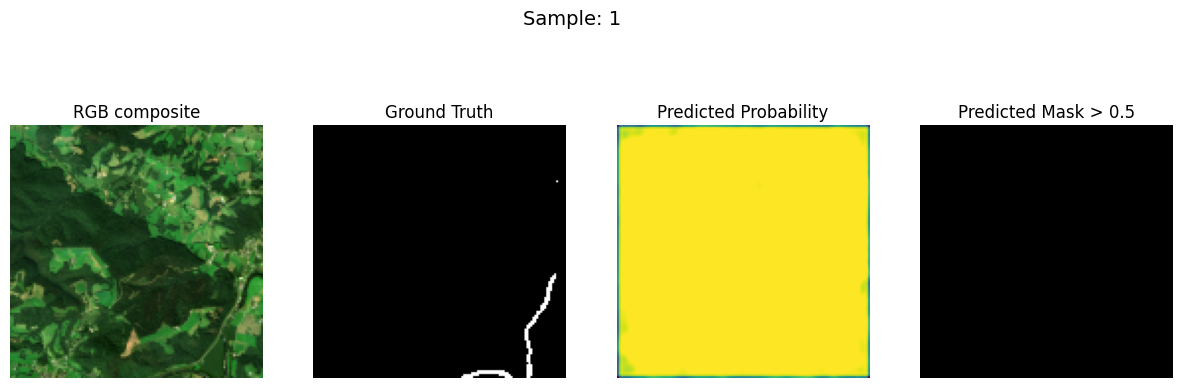

In [49]:
def show_prediction(model, dataset, idx=0, threshold=0.5, band_indices={'red':3,'green':2,'blue':1}):
    model.eval()
    img, mask, name = dataset[idx]
    img_t = img.unsqueeze(0).to(device)
    with torch.no_grad():
        pred = torch.sigmoid(model(img_t))[0,0].cpu().numpy()
    pred_bin = (pred > threshold).astype(np.uint8)
    mask = mask.numpy()
    
    # try to construct RGB if possible
    C,H,W = img.shape
    rgb = None
    if all(k in band_indices for k in ('red','green','blue')):
        if band_indices['red']<C and band_indices['green']<C and band_indices['blue']<C:
            r = img[band_indices['red']].numpy()
            g = img[band_indices['green']].numpy()
            b = img[band_indices['blue']].numpy()
            rgb = np.stack([r,g,b],axis=-1)
            rgb = (rgb - rgb.min())/(rgb.max()-rgb.min()+1e-9)
    
    # plot
    plt.figure(figsize=(15,5))
    if rgb is not None:
        plt.subplot(1,4,1); plt.imshow(rgb); plt.title("RGB composite"); plt.axis("off")
    else:
        plt.subplot(1,4,1); plt.imshow(img[0],cmap="gray"); plt.title("Band 0"); plt.axis("off")
    plt.subplot(1,4,2); plt.imshow(mask,cmap="gray"); plt.title("Ground Truth"); plt.axis("off")
    plt.subplot(1,4,3); plt.imshow(pred,cmap="viridis"); plt.title("Predicted Probability"); plt.axis("off")
    plt.subplot(1,4,4); plt.imshow(pred_bin,cmap="gray"); plt.title(f"Predicted Mask > {threshold}"); plt.axis("off")
    plt.suptitle(f"Sample: {name}", fontsize=14)
    plt.show()

# Example usage: show a sample from validation set
show_prediction(model, val_ds, idx=0)

# Visualization Function

In [50]:
def visualize_prediction(model, dataset, idx=0):
    model.eval()
    X, y_true = dataset[idx]
    with torch.no_grad():
        X = X.unsqueeze(0).to(device)
        y_pred = model(X).cpu().squeeze().numpy()

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(X.cpu().squeeze()[0], cmap="gray")  
    ax[0].set_title("Input (Band 1)")
    ax[1].imshow(y_true.squeeze(), cmap="gray")
    ax[1].set_title("Ground Truth")
    ax[2].imshow(y_pred > 0.5, cmap="gray")
    ax[2].set_title("Prediction")
    plt.show()

# Show multiple validation samples

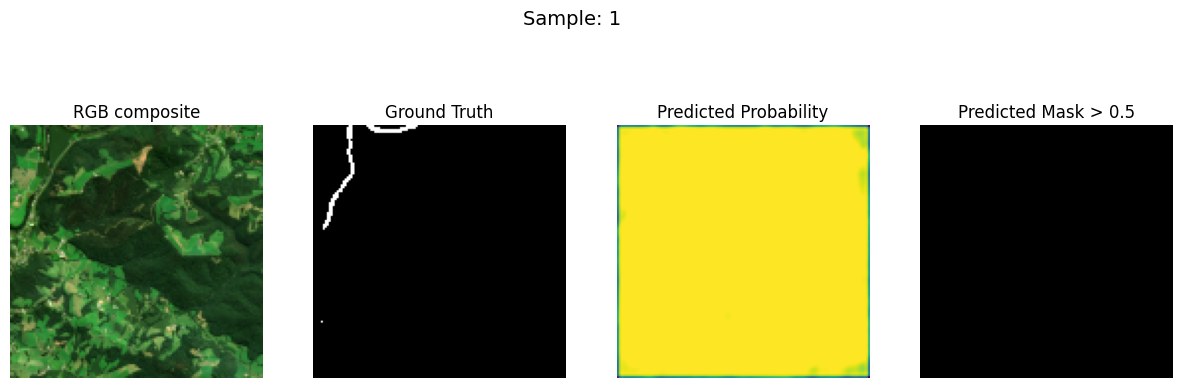

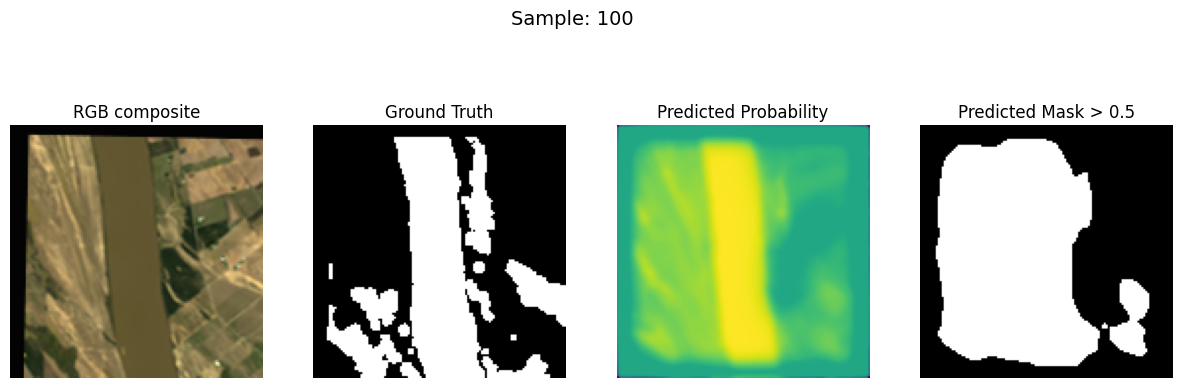

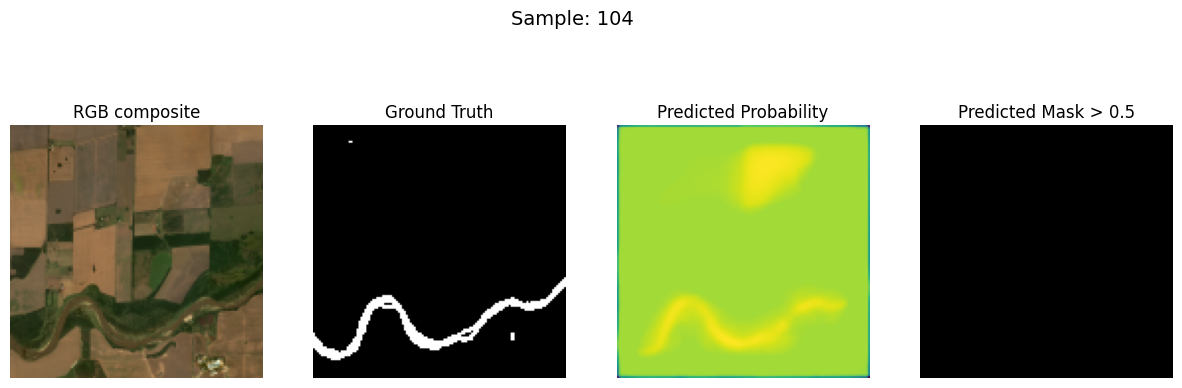

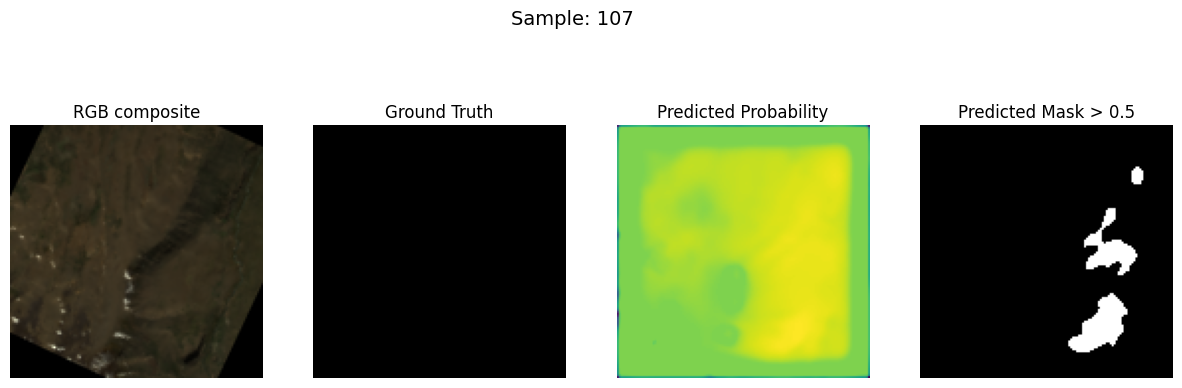

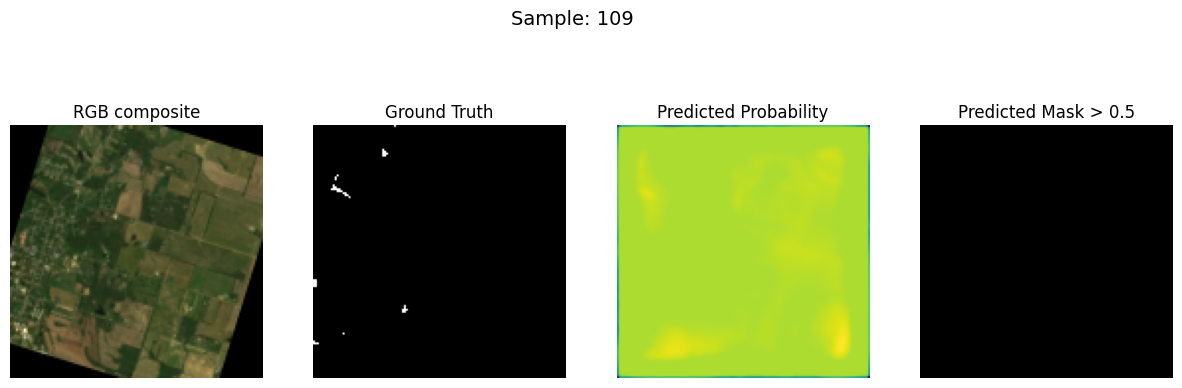

In [51]:
for i in range(min(5, len(val_ds))):  
    show_prediction(model, val_ds, idx=i)

# Inspect band contributions

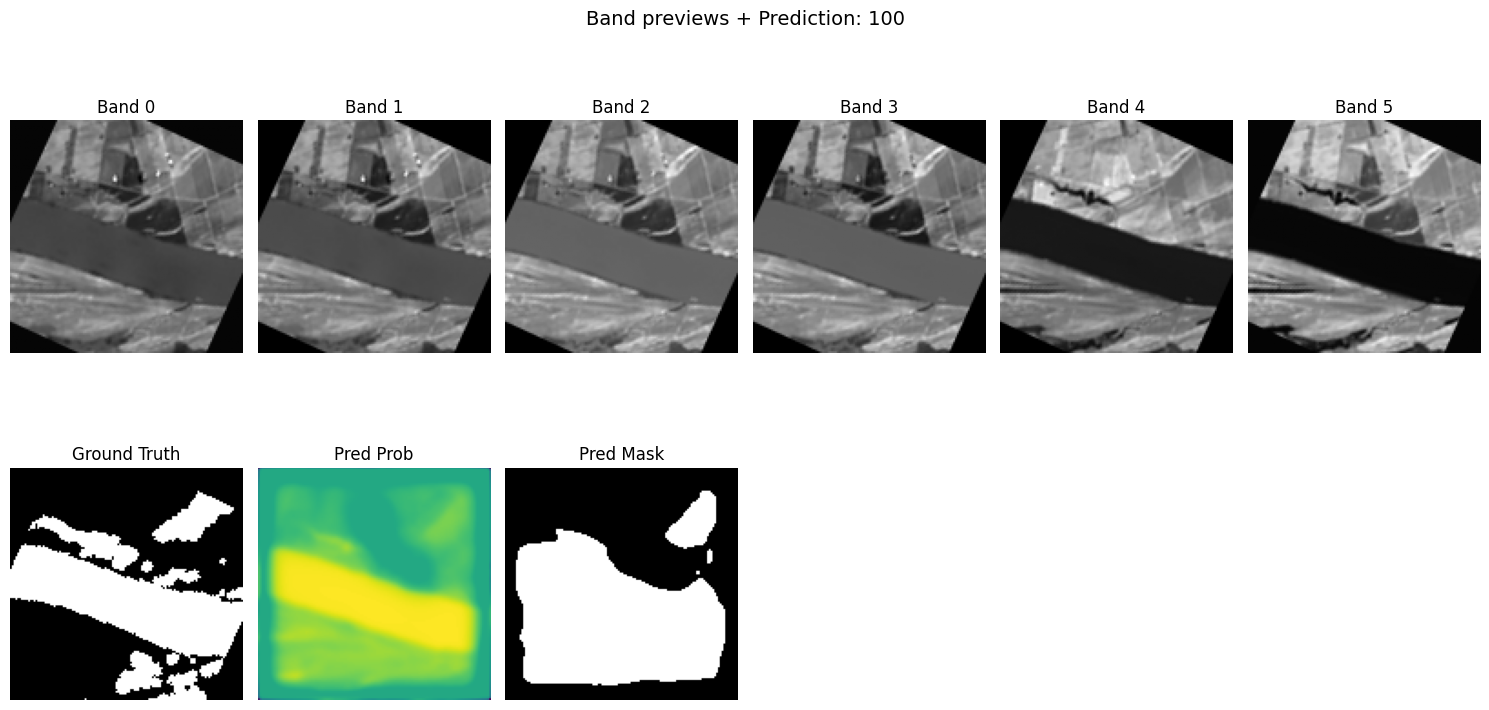

In [52]:
def show_bands_with_prediction(model, dataset, idx=0, max_bands=6, threshold=0.5):
    img, mask, name = dataset[idx]
    img_t = img.unsqueeze(0).to(device)
    with torch.no_grad():
        pred = torch.sigmoid(model(img_t))[0,0].cpu().numpy()
    pred_bin = (pred > threshold).astype(np.uint8)
    
    C,H,W = img.shape
    n = min(C, max_bands)
    plt.figure(figsize=(15, 8))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(img[i], cmap="gray")
        plt.title(f"Band {i}")
        plt.axis("off")
    plt.subplot(2, n, n+1)
    plt.imshow(mask, cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")
    plt.subplot(2, n, n+2)
    plt.imshow(pred, cmap="viridis")
    plt.title("Pred Prob")
    plt.axis("off")
    plt.subplot(2, n, n+3)
    plt.imshow(pred_bin, cmap="gray")
    plt.title("Pred Mask")
    plt.axis("off")
    plt.suptitle(f"Band previews + Prediction: {name}", fontsize=14)
    plt.tight_layout()
    plt.show()

# Example usage
show_bands_with_prediction(model, val_ds, idx=1)

# Confusion Matrix on Validation Set

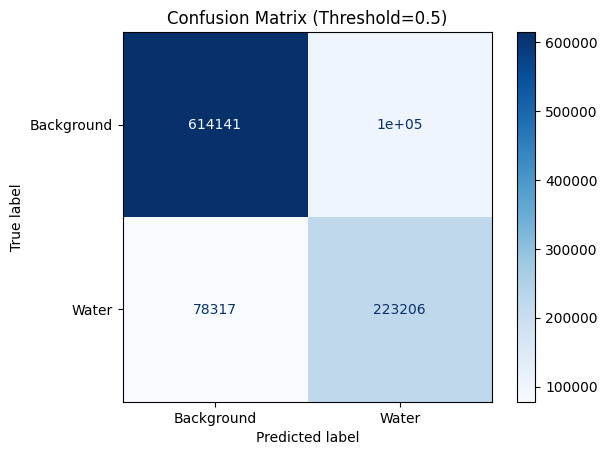

In [53]:
def evaluate_confusion_matrix(model, loader, device, threshold=0.5):
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for imgs, masks, _ in loader:
            imgs = imgs.to(device)
            masks = masks.to(device).view(-1).cpu().numpy()
            preds = torch.sigmoid(model(imgs)).view(-1).cpu().numpy()
            preds_bin = (preds > threshold).astype(int)
            y_true.extend(masks.tolist())
            y_pred.extend(preds_bin.tolist())
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Background","Water"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix (Threshold={threshold})")
    plt.show()

# Example usage
evaluate_confusion_matrix(model, val_loader, device, threshold=0.5)

# ROC Curve on Validation Set

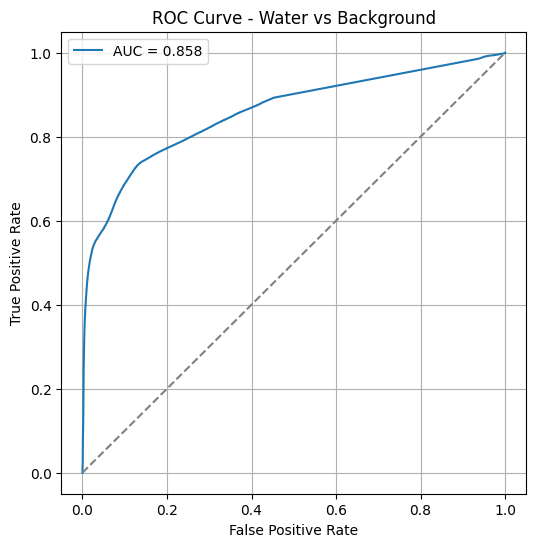

In [54]:
def plot_roc_curve(model, loader, device):
    y_true, y_score = [], []
    model.eval()
    with torch.no_grad():
        for imgs, masks, _ in loader:
            imgs = imgs.to(device)
            masks = masks.to(device).view(-1).cpu().numpy()
            preds = torch.sigmoid(model(imgs)).view(-1).cpu().numpy()
            y_true.extend(masks.tolist())
            y_score.extend(preds.tolist())
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Water vs Background")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_roc_curve(model, val_loader, device)

# Precision-Recall (PR) Curve on Validation Set

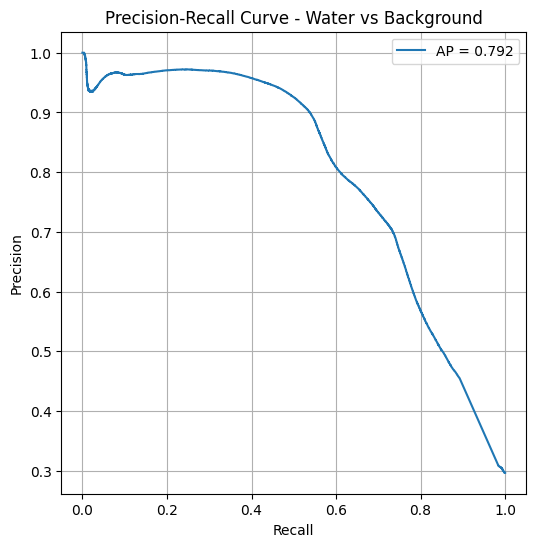

In [55]:
def plot_pr_curve(model, loader, device):
    y_true, y_score = [], []
    model.eval()
    with torch.no_grad():
        for imgs, masks, _ in loader:
            imgs = imgs.to(device)
            masks = masks.to(device).view(-1).cpu().numpy()
            preds = torch.sigmoid(model(imgs)).view(-1).cpu().numpy()
            y_true.extend(masks.tolist())
            y_score.extend(preds.tolist())
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)

    plt.figure(figsize=(6,6))
    plt.plot(recall, precision, label=f"AP = {ap:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve - Water vs Background")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_pr_curve(model, val_loader, device)

# Overlay Predicted Mask on RGB

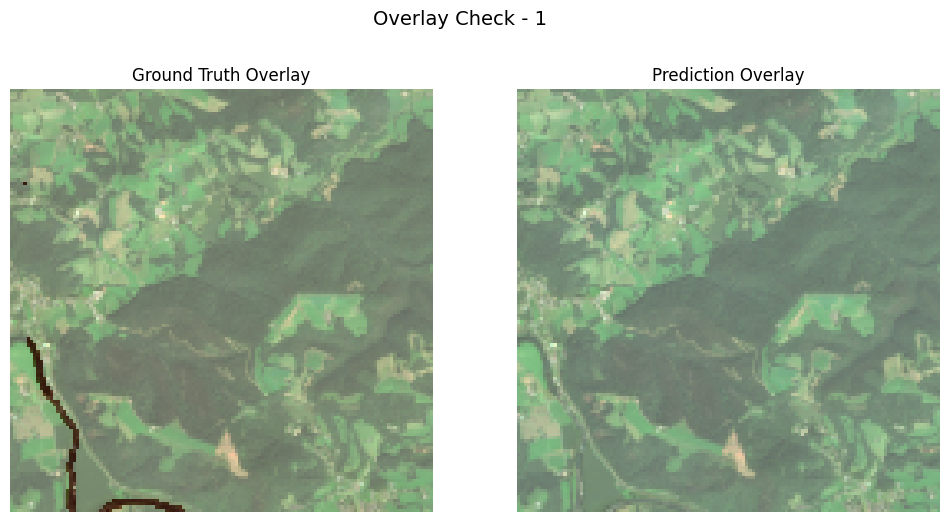

In [56]:
def overlay_prediction(model, dataset, idx=0, threshold=0.5, band_indices={'red':3,'green':2,'blue':1}):
    model.eval()
    img, mask, name = dataset[idx]
    img_t = img.unsqueeze(0).to(device)
    with torch.no_grad():
        pred = torch.sigmoid(model(img_t))[0,0].cpu().numpy()
    pred_bin = (pred > threshold).astype(np.uint8)
    mask = mask.numpy()

    # Build RGB composite
    C,H,W = img.shape
    rgb = None
    if all(k in band_indices for k in ('red','green','blue')):
        if band_indices['red']<C and band_indices['green']<C and band_indices['blue']<C:
            r,g,b = img[band_indices['red']], img[band_indices['green']], img[band_indices['blue']]
            rgb = np.stack([r,g,b],axis=-1)
            rgb = (rgb - rgb.min())/(rgb.max()-rgb.min()+1e-9)
    
    if rgb is None:
        print("Could not construct RGB, using Band 0 as grayscale.")
        rgb = np.repeat(img[0][...,None],3,axis=-1)

    # Overlay (Ground Truth vs Prediction)
    plt.figure(figsize=(12,6))
    
    # Ground Truth Overlay
    plt.subplot(1,2,1)
    plt.imshow(rgb)
    plt.imshow(mask, cmap="Reds", alpha=0.4)
    plt.title("Ground Truth Overlay")
    plt.axis("off")
    
    # Predicted Overlay
    plt.subplot(1,2,2)
    plt.imshow(rgb)
    plt.imshow(pred_bin, cmap="Blues", alpha=0.4)
    plt.title("Prediction Overlay")
    plt.axis("off")
    
    plt.suptitle(f"Overlay Check - {name}", fontsize=14)
    plt.show()

# Example usage
overlay_prediction(model, val_ds, idx=0)

# IoU/F1 vs Threshold Plot

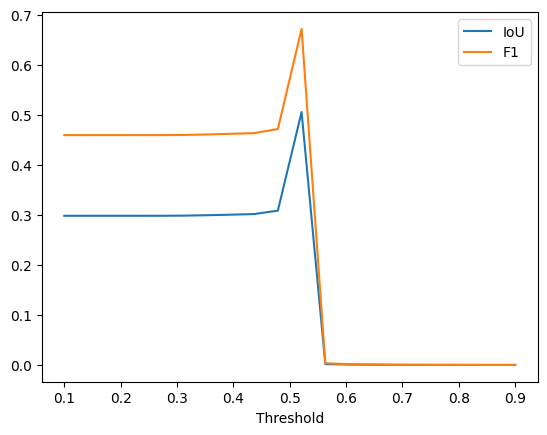

In [57]:
def plot_iou_f1_vs_threshold(model, loader, device):
    y_true, y_score = [], []
    model.eval()
    with torch.no_grad():
        for imgs, masks, _ in loader:
            imgs = imgs.to(device)
            masks = masks.to(device).view(-1).cpu().numpy()
            preds = torch.sigmoid(model(imgs)).view(-1).cpu().numpy()
            y_true.extend(masks.tolist())
            y_score.extend(preds.tolist())
    if sum(y_true) == 0:
        print("No water samples in val set—plot invalid.")
    else:
        thresholds = np.linspace(0.1, 0.9, 20)
        ious, f1s = [], []
        for th in thresholds:
            preds_bin = (np.array(y_score) > th).astype(int)
            cm = confusion_matrix(y_true, preds_bin)
            tn, fp, fn, tp = cm.ravel()
            iou_val = tp / (tp + fn + fp + 1e-6)
            f1_val = (2 * tp) / (2 * tp + fn + fp + 1e-6)
            ious.append(iou_val)
            f1s.append(f1_val)
        plt.plot(thresholds, ious, label="IoU")
        plt.plot(thresholds, f1s, label="F1")
        plt.xlabel("Threshold")
        plt.legend()
        plt.show()

# Call plot
plot_iou_f1_vs_threshold(model, val_loader, device)

# Deployment

In [58]:
import torch
from pathlib import Path

# Save model state from memory
if 'model' in globals():
    model_path = Path("final_model.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Saved model to {model_path.absolute()}")
else:
    print("Model not in memory. You must rerun training cells.")

Saved model to /mnt/c/Users/Rowan/Desktop/Cellula_Internship/Task2/final_model.pth


In [59]:
import json
from pathlib import Path

if 'normalize_stats' in globals():
    with open('normalize_stats.json', 'w') as f:
        json.dump({'mean': normalize_stats['mean'].tolist(), 'std': normalize_stats['std'].tolist()}, f)
    print("Saved normalize_stats to normalize_stats.json")
else:
    print("normalize_stats not defined. Recompute with compute_dataset_stats(full_dataset).")

Saved normalize_stats to normalize_stats.json
